Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
def decorrelate(num_epochs, data, model):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        # model.weight -= lr * model.weight.grad
        print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

iteration 0	loss: 0.022
iteration 1	loss: 0.020
iteration 2	loss: 0.021
iteration 3	loss: 0.020
iteration 4	loss: 0.021
iteration 5	loss: 0.020
iteration 6	loss: 0.021
iteration 7	loss: 0.019
iteration 8	loss: 0.021
iteration 9	loss: 0.019
iteration 10	loss: 0.020
iteration 11	loss: 0.019
iteration 12	loss: 0.020
iteration 13	loss: 0.019
iteration 14	loss: 0.020
iteration 15	loss: 0.018
iteration 16	loss: 0.020
iteration 17	loss: 0.018
iteration 18	loss: 0.019
iteration 19	loss: 0.018
iteration 20	loss: 0.019
iteration 21	loss: 0.018
iteration 22	loss: 0.019
iteration 23	loss: 0.018
iteration 24	loss: 0.019
iteration 25	loss: 0.017
iteration 26	loss: 0.019
iteration 27	loss: 0.017
iteration 28	loss: 0.018
iteration 29	loss: 0.017
iteration 30	loss: 0.018
iteration 31	loss: 0.017
iteration 32	loss: 0.018
iteration 33	loss: 0.017
iteration 34	loss: 0.018
iteration 35	loss: 0.016
iteration 36	loss: 0.017
iteration 37	loss: 0.016
iteration 38	loss: 0.017
iteration 39	loss: 0.016
iteration 

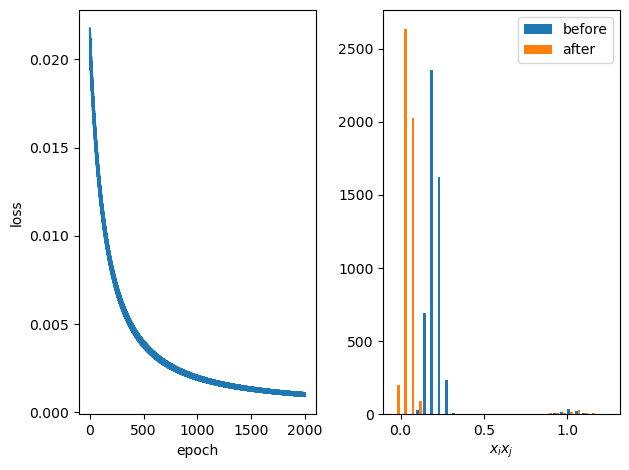

In [3]:
num_samples=1000
num_features=100
num_epochs=2000
seed=42
lr=1e-4 # huge loss spike at 1e-3

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

# create a decorrelator
model = Decorrelation(in_features=num_features, eta=lr)

L, A1, A2 = decorrelate(num_epochs, data, model) 

plt.figure()
plt.subplot(1,2,1)
plt.plot(L)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
plt.legend()
plt.xlabel('$x_i x_j$')
plt.legend();
plt.tight_layout()

Parameter containing:
tensor([[ 1.1199e+00, -8.6193e-03, -6.8136e-03,  ..., -7.7263e-03,
         -1.3476e-02, -7.3307e-03],
        [-7.5791e-03,  1.0769e+00, -5.8522e-03,  ..., -2.1921e-03,
         -3.1232e-03, -1.9724e-02],
        [-6.8830e-03, -6.6944e-03,  1.1316e+00,  ..., -1.0196e-02,
         -1.0407e-03, -1.1213e-02],
        ...,
        [-7.5203e-03, -2.3742e-03, -9.8206e-03,  ...,  1.1181e+00,
          1.8539e-03, -1.5209e-02],
        [-1.1160e-02, -2.9758e-03, -9.7188e-04,  ...,  1.4531e-03,
          1.0756e+00, -7.2782e-03],
        [-7.0862e-03, -2.1747e-02, -1.0722e-02,  ..., -1.5081e-02,
         -8.4279e-03,  1.1364e+00]])

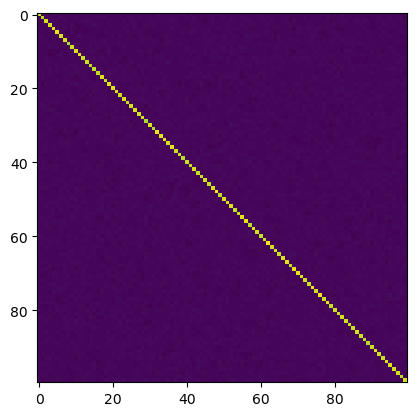

In [4]:
# we learn a lower triangular matrix
plt.imshow(model.weight.detach().numpy());
model.weight

Decorrelation of correlated input using DecorConv2d

iteration 0	loss: 0.452
iteration 1	loss: 0.210
iteration 2	loss: 0.621
iteration 3	loss: 0.233
iteration 4	loss: 0.359
iteration 5	loss: 0.482
iteration 6	loss: 0.166
iteration 7	loss: 0.988
iteration 8	loss: 0.167
iteration 9	loss: 0.527
iteration 10	loss: 0.233
iteration 11	loss: 0.446
iteration 12	loss: 0.214
iteration 13	loss: 0.472
iteration 14	loss: 0.269
iteration 15	loss: 0.342
iteration 16	loss: 0.417
iteration 17	loss: 0.189
iteration 18	loss: 0.636
iteration 19	loss: 0.123
iteration 20	loss: 1.066
iteration 21	loss: 0.064
iteration 22	loss: 1.911
iteration 23	loss: 0.081
iteration 24	loss: 0.790
iteration 25	loss: 0.129
iteration 26	loss: 0.355
iteration 27	loss: 0.281
iteration 28	loss: 0.282
iteration 29	loss: 0.163
iteration 30	loss: 0.621
iteration 31	loss: 0.115
iteration 32	loss: 0.726
iteration 33	loss: 0.072
iteration 34	loss: 1.366
iteration 35	loss: 0.035
iteration 36	loss: 3.992
iteration 37	loss: 0.026
iteration 38	loss: 8.542
iteration 39	loss: 0.024
iteration 

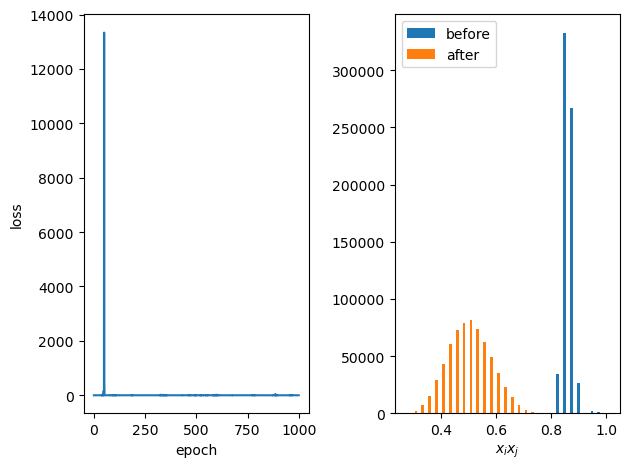

In [5]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=1000
seed=42
lr=1e-3 # huge loss spike at 1e-3
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

# create a convolutional decorrelator
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, eta=lr, downsample_perc=downsample_perc)

L, A1, A2 = decorrelate(num_epochs, data, model) 

plt.figure()
plt.subplot(1,2,1)
plt.plot(L)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
plt.legend()
plt.xlabel('$x_i x_j$')
plt.legend();
plt.tight_layout()

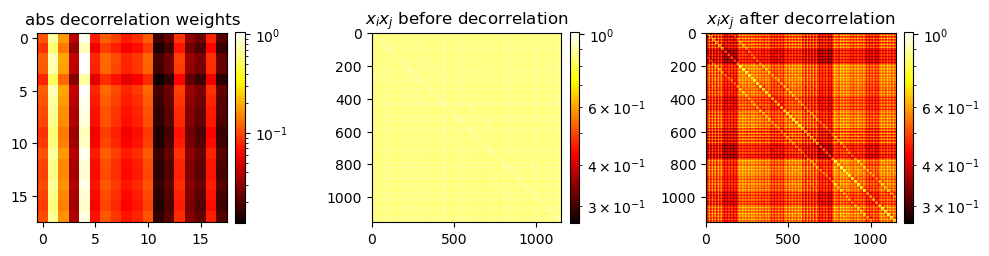

In [6]:
import matplotlib 
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
min = np.min(np.abs(model.weight.numpy().flatten()))
max = np.max(np.abs(model.weight.numpy().flatten()))
plt.imshow(np.abs(model.weight), cmap=plt.get_cmap('hot'), interpolation='nearest', norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
plt.title('abs decorrelation weights')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,3,2)
min = np.min(np.stack([A1.numpy().flatten(), A2.numpy().flatten()]))
max = np.max(np.stack([A1.numpy().flatten(), A2.numpy().flatten()]))
plt.imshow(A1, cmap=plt.get_cmap('hot'), interpolation='nearest', norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
plt.title('$x_i x_j$ before decorrelation')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,3,3)
plt.imshow(A2, cmap=plt.get_cmap('hot'), interpolation='nearest', norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
plt.title('$x_i x_j$ after decorrelation')
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

In [7]:
np.diag(A2)

array([0.73306066, 0.46402615, 0.8399693 , ..., 0.5866861 , 0.5272936 ,
       0.6632327 ], dtype=float32)

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison